# Creating tools

## Is It Worth Automating? A Time-Saving Tradeoff Simulation

### Goal

This notebook helps evaluate **when it’s worth building a tool** to automate a repetitive task.

We compare:

- The **cumulative time cost** of doing a task manually (many times per year)
- Against the **one-time development cost** (in days) of building a tool to automate it

We introduce a threshold:  
👉 _A tool is considered worth building if it recovers at least X% of its development time in one year._

This lets us answer questions like:

- _“If I do a 10-minute task 500 times a year, is it worth spending 3 days to automate it?”_
- _“At what point does a 1-minute savings add up enough to justify tool development?”_

### Simulation Parameters

| Parameter             | Description                                                           |
| --------------------- | --------------------------------------------------------------------- |
| `frequency_per_year`  | How often the task is done per year (log scale: 1 to 10,000)          |
| `time_per_task_min`   | Time each task takes manually (log scale: 0.1 to 100 minutes)         |
| `dev_time_days`       | Time needed to build the automation tool (log scale: 0.1 to 100 days) |
| `justification_ratio` | Threshold to consider the tool worth it (e.g., 50%)                   |

### Outputs

- A **log-scaled heatmap** showing when tool building is justified based on:
  - Frequency of the task
  - Manual task duration
  - Fixed dev time
- A **decision table** showing scenarios where automation is worth it


Using dev_time_days = 10.000


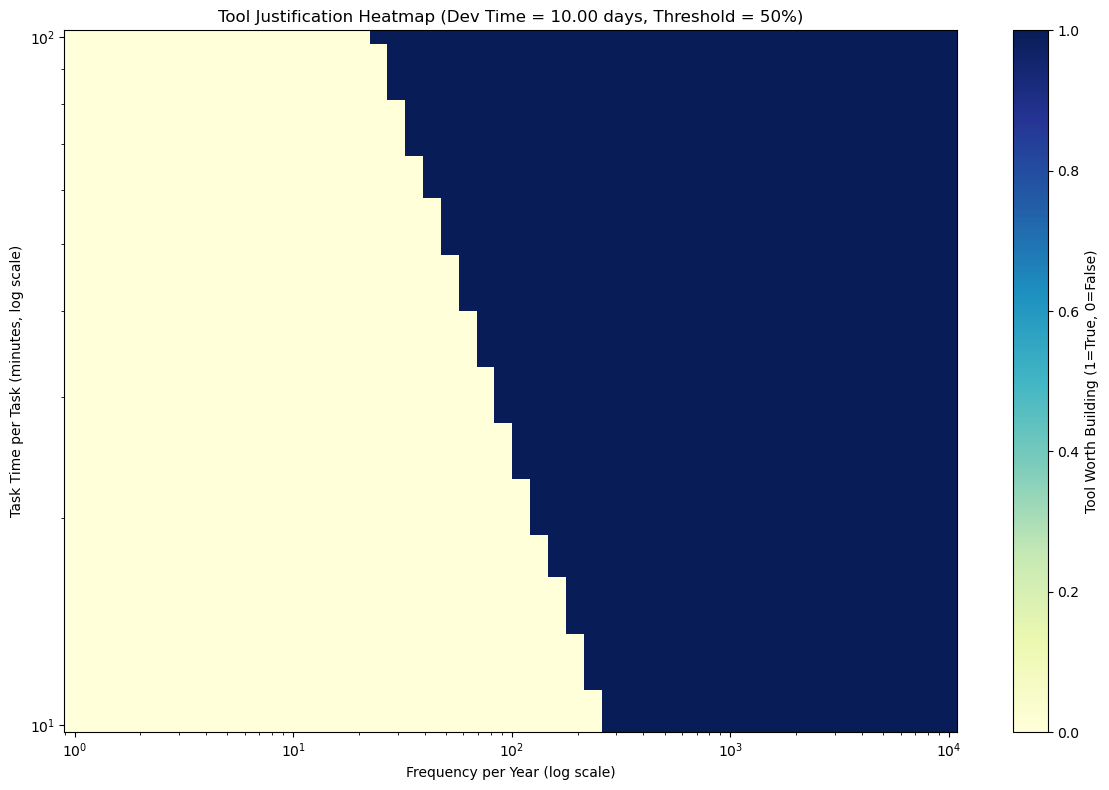

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
frequencies = np.logspace(0, 4, num=50)  # 1 to 10,000 times per year
times_per_task = np.logspace(1, 2, num=50)  # 1 to 100 minutes
dev_times_days = np.logspace(1, 2, num=50)  # 1 to 100 days
justification_ratio = (
    0.5  # 50% of time recovered is enough to justify the devlopment effort
)

# Find closest to 5
target_dev_time = 5

# Fixed conversion
minutes_per_day = 60 * 8  # Assuming 8-hour workdays

closest_value = dev_times_days[np.abs(dev_times_days - target_dev_time).argmin()]
print(f"Using dev_time_days = {closest_value:.3f}")


# Create simulation results
results = []
for freq in frequencies:
    for task_time in times_per_task:
        for dev_days in dev_times_days:
            yearly_manual_time = freq * task_time  # in minutes
            yearly_automated_time = freq * 1  # reduced to 1 minute per task
            time_saved_yearly = yearly_manual_time - yearly_automated_time

            dev_time_minutes = dev_days * minutes_per_day

            is_worth_it = time_saved_yearly >= (justification_ratio * dev_time_minutes)

            results.append(
                {
                    "frequency": freq,
                    "task_time_min": task_time,
                    "dev_time_days": dev_days,
                    "dev_time_min": dev_time_minutes,
                    "time_saved": time_saved_yearly,
                    "worth_it": is_worth_it,
                }
            )

# Convert to DataFrame
df = pd.DataFrame(results)

# Let's fix dev_time_days for the heatmap slice
dev_time_slice = 5  # e.g., fix at 5 days of dev
tolerance = 1e-3
df_slice = df[np.isclose(df["dev_time_days"], closest_value, atol=tolerance)]

# Sanity check
if df_slice.empty:
    raise ValueError(
        f"No data found for dev_time_days ≈ {dev_time_slice} and closest_value ≈ {closest_value}"
    )

# Get unique x and y values from your filtered slice
x = np.sort(df_slice["frequency"].unique())
y = np.sort(df_slice["task_time_min"].unique())

# Prepare 2D array of "worth_it" values
z = (
    df_slice.pivot_table(
        index="task_time_min", columns="frequency", values="worth_it", aggfunc="first"
    )
    .reindex(index=y, columns=x)
    .fillna(False)
    .astype(float)
    .values
)

# Create plot
plt.figure(figsize=(12, 8))
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, z, shading="auto", cmap="YlGnBu")

# Set log scale
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Frequency per Year (log scale)")
plt.ylabel("Task Time per Task (minutes, log scale)")
plt.title(
    f"Tool Justification Heatmap (Dev Time = {closest_value:.2f} days, Threshold = {justification_ratio*100:.0f}%)"
)

# Colorbar
cbar = plt.colorbar()
cbar.set_label("Tool Worth Building (1=True, 0=False)")

plt.tight_layout()
plt.show()